In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from botorch.models.transforms.input import AffineInputTransform

from Neural_Net_Classes import NN as NN

import numpy as np

from Neural_Net_Classes import NN as NN
from Neural_Net_Classes import Calibration as Calibration
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F


In [2]:
# Load the simulaiton CSV file
sim_training_set_df = pd.read_csv('../../simulation_data/simulation_data.csv')

# Load the experimental train and test sets
expt_training_set_df = pd.read_csv('../../experimental_data/training_set_1.csv')
expt_test_set_df = pd.read_csv('../../experimental_data/test_set_1.csv')

<Figure size 640x480 with 0 Axes>

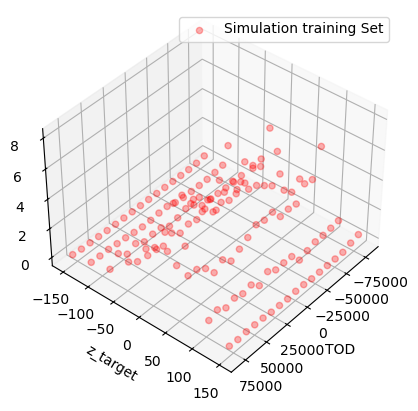

In [3]:
# Access the arrays
sim_z_training_set = sim_training_set_df['z_target_um'].values
sim_TOD_training_set = sim_training_set_df['TOD_fs3'].values
sim_protons_training_set = sim_training_set_df['n_protons'].values

plt.clf()
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( sim_TOD_training_set, sim_z_training_set, sim_protons_training_set, c='r',alpha=0.3, label='Simulation training Set')
ax.view_init(elev=40., azim=40)
plt.xlabel('TOD')
plt.ylabel('z_target')
plt.legend()

<h2> Normalize with Affine Input Transformer

In [4]:

# Define the input and output normalizations, based on the training set from experiments
X = torch.tensor(expt_training_set_df[['z_target_um', 'TOD_fs3','GVD']].values, dtype=torch.float)
input_transform = AffineInputTransform(3, coefficient=X.std(axis=0), offset=X.mean(axis=0))
y = torch.tensor(expt_training_set_df['n_protons'].values, dtype=torch.float).reshape(-1,1)
output_transform = AffineInputTransform( 1, coefficient=y.std(axis=0), offset=y.mean(axis=0))
if (min(X.mean(axis=0)) == 0):
    print("Mean value used for normalization is 0. This will lead to NaNs ",X.mean(axis=0))
if (min(X.std(axis=0)) == 0):
    print("RMS value used for normalization is 0. This will lead to NaNs ", X.std(axis=0))


In [5]:
# Apply normalization to the training and test sets
norm_sim_training_set_df = sim_training_set_df.copy()
norm_sim_training_set_df[['z_target_um', 'TOD_fs3','GVD']] = input_transform( torch.tensor( sim_training_set_df[['z_target_um', 'TOD_fs3','GVD']].values ) )
norm_sim_training_set_df[['n_protons']] = output_transform( torch.tensor( sim_training_set_df[['n_protons']].values.reshape(-1,1) ) )




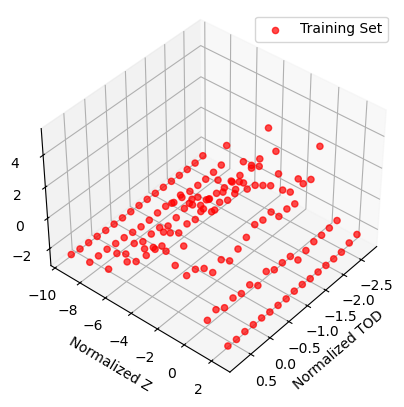

In [6]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter( norm_sim_training_set_df['TOD_fs3'], norm_sim_training_set_df['z_target_um'],
           norm_sim_training_set_df['n_protons'], c='r', alpha=0.7, label='Training Set')

ax.view_init(elev=40., azim=40, roll=0)
# Set labels and title
ax.set_xlabel('Normalized TOD')
ax.set_ylabel('Normalized Z')
ax.set_zlabel('Normalized Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

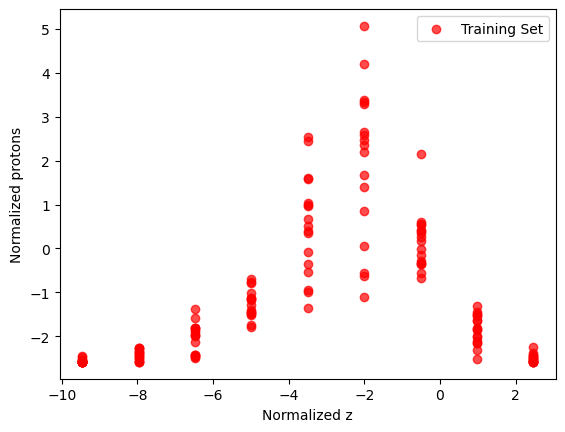

In [7]:
# Create a 2D plot
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(norm_sim_training_set_df['z_target_um'],
           norm_sim_training_set_df['n_protons'], c='r', alpha=0.7, label='Training Set')

# Set labels and title
ax.set_xlabel('Normalized z')
ax.set_ylabel('Normalized protons')

# Add legend
ax.legend()
# Show plot
plt.show()

In [8]:
norm_sim_inputs_training = torch.tensor( norm_sim_training_set_df[['z_target_um', 'TOD_fs3','GVD']].values, dtype=torch.float)
norm_sim_outputs_training = torch.tensor( norm_sim_training_set_df['n_protons'].values.reshape(-1,1), dtype=torch.float)



<h2> Train base neural net

Epoch [1000/10000], Loss:0.872343
Epoch [2000/10000], Loss:0.328455
Epoch [3000/10000], Loss:0.183324
Epoch [4000/10000], Loss:0.148057
Epoch [5000/10000], Loss:0.122186
Epoch [6000/10000], Loss:0.107036
Epoch [7000/10000], Loss:0.095796
Epoch [8000/10000], Loss:0.085590
Epoch [9000/10000], Loss:0.073560
Epoch [10000/10000], Loss:0.062472


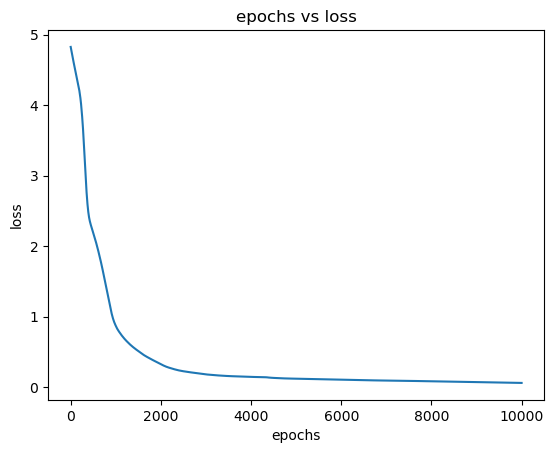

In [9]:
sim_net = NN(learning_rate=0.0001)
sim_net.train_model(norm_sim_inputs_training, norm_sim_outputs_training,num_epochs=10000)

sim_net.plot_loss()

In [10]:
sim_train_predictions = sim_net.predict(norm_sim_inputs_training)

<h2> Visualize NN prediction on same data that it was training on

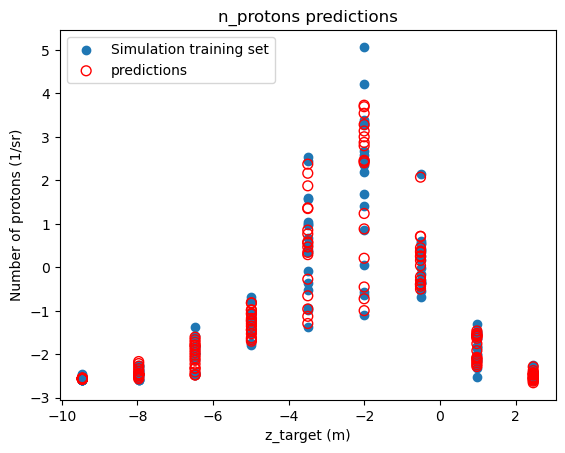

In [11]:
fig, ax = plt.subplots()

ax.scatter(norm_sim_training_set_df['z_target_um'], norm_sim_training_set_df['n_protons'], label='Simulation training set')

ax.scatter(norm_sim_training_set_df['z_target_um'], sim_train_predictions, label='predictions', s=50, facecolors='none', edgecolors='r')

plt.title("n_protons predictions")
plt.xlabel('z_target (m)')
plt.ylabel('Number of protons (1/sr)')
plt.legend()

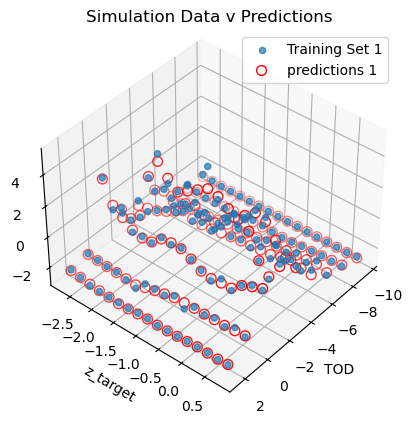

In [12]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for training set
ax.scatter(norm_sim_training_set_df['z_target_um'], norm_sim_training_set_df['TOD_fs3'], norm_sim_training_set_df['n_protons'], label='Training Set 1', alpha=0.7)


ax.scatter(norm_sim_training_set_df['z_target_um'], norm_sim_training_set_df['TOD_fs3'], sim_train_predictions, label='predictions 1', s=50, facecolors='none', edgecolors='r')
#ax.scatter(test_predictions['TOD'], test_predictions['Z_target'], test_predictions['predictions'], s=50, facecolors='none', edgecolors='r')

ax.view_init(elev=40., azim=40)
# Set labels and title
ax.set_title('Simulation Data v Predictions')
ax.set_xlabel('TOD')
ax.set_ylabel('z_target')
ax.set_zlabel('n Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

<h2> Normalize training and test set from experiments </h2> 

In [13]:
# Apply normalization to the training and test sets from experiments
norm_expt_training_set_df = expt_training_set_df.copy()
norm_expt_training_set_df[['z_target_um', 'TOD_fs3','GVD']] = input_transform( torch.tensor( expt_training_set_df[['z_target_um', 'TOD_fs3','GVD']].values ) )
norm_expt_training_set_df[['n_protons']] = output_transform( torch.tensor( expt_training_set_df[['n_protons']].values.reshape(-1,1) ) )


norm_expt_test_set_df = expt_test_set_df.copy()
norm_expt_test_set_df[['z_target_um', 'TOD_fs3','GVD']] = input_transform( torch.tensor( expt_test_set_df[['z_target_um', 'TOD_fs3','GVD']].values ) )
norm_expt_test_set_df[['n_protons']] = output_transform( torch.tensor( expt_test_set_df[['n_protons']].values.reshape(-1,1) ) )

norm_expt_inputs_training = torch.tensor( norm_expt_training_set_df[['z_target_um', 'TOD_fs3','GVD']].values, dtype=torch.float)
norm_expt_outputs_training = torch.tensor( norm_expt_training_set_df['n_protons'].values.reshape(-1,1), dtype=torch.float)

norm_expt_inputs_test = torch.tensor( norm_expt_test_set_df[['z_target_um', 'TOD_fs3','GVD']].values, dtype=torch.float)
norm_expt_outputs_test = torch.tensor( norm_expt_test_set_df['n_protons'].values.reshape(-1,1), dtype=torch.float)


<h2> Set pretrained model, add Linear calibration layer, and train w & b of calibration layer

Comb NN: Epoch [1000/10000], Loss:1.208157
Calibration Layer Weight: -0.1752471625804901
Calibration Layer Bias: -0.1705017238855362
Comb NN: Epoch [2000/10000], Loss:0.921196
Calibration Layer Weight: 0.14566269516944885
Calibration Layer Bias: 0.11426696926355362
Comb NN: Epoch [3000/10000], Loss:0.915437
Calibration Layer Weight: 0.19467854499816895
Calibration Layer Bias: 0.157674178481102
Comb NN: Epoch [4000/10000], Loss:0.915432
Calibration Layer Weight: 0.19504305720329285
Calibration Layer Bias: 0.15799695253372192
Comb NN: Epoch [5000/10000], Loss:0.915432
Calibration Layer Weight: 0.19504305720329285
Calibration Layer Bias: 0.15799695253372192
Comb NN: Epoch [6000/10000], Loss:0.915432
Calibration Layer Weight: 0.19504305720329285
Calibration Layer Bias: 0.15799695253372192
Comb NN: Epoch [7000/10000], Loss:0.915432
Calibration Layer Weight: 0.19504305720329285
Calibration Layer Bias: 0.15799695253372192
Comb NN: Epoch [8000/10000], Loss:0.915432
Calibration Layer Weight: 0.

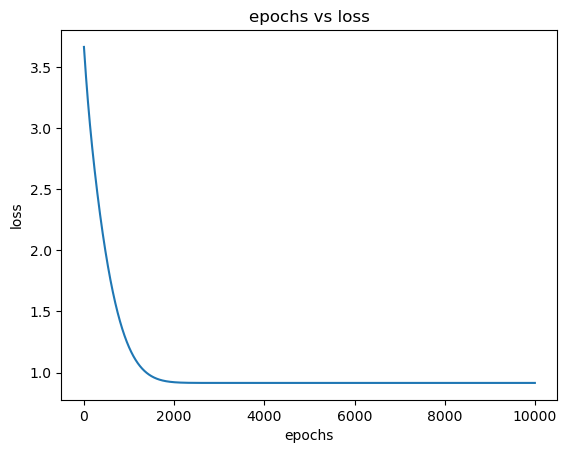

In [14]:
# Load the pre-trained model
base_model = sim_net
output_dim = sim_train_predictions.shape[1]
# Add a linear layer on top
calibration_layer = nn.Linear(output_dim, 1)
criterion = nn.MSELoss()

calibrated_nn = Calibration(sim_net, criterion, calibration_layer)
train_on_expt = calibrated_nn.train(norm_expt_inputs_training, norm_expt_outputs_training)
calibrated_nn.plot_loss()

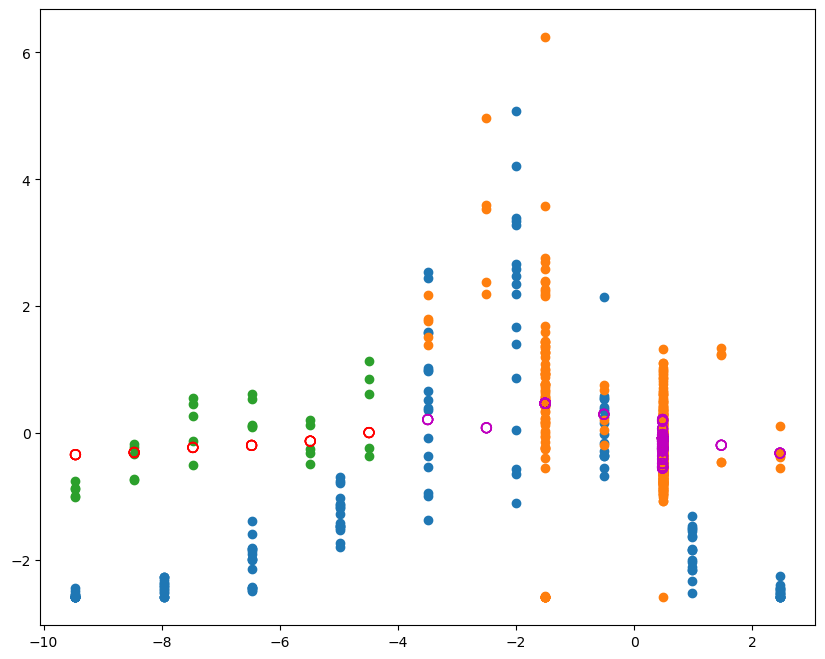

In [15]:

test_on_expt = calibrated_nn.predict(norm_expt_inputs_test)
test_on_trainexpt = calibrated_nn.predict(norm_expt_inputs_training)
test_on_basemodel = sim_net.predict(norm_expt_inputs_test)
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(norm_sim_training_set_df['z_target_um'], norm_sim_training_set_df['n_protons'], label='Simulation training set')
ax.scatter(norm_expt_training_set_df['z_target_um'], norm_expt_training_set_df['n_protons'], label='Expt training set')
ax.scatter(norm_expt_test_set_df['z_target_um'], norm_expt_test_set_df['n_protons'], label='Expt test set')

ax.scatter(norm_expt_training_set_df['z_target_um'], test_on_trainexpt, label=' expt train predictions', s=50, facecolors='none', edgecolors='m')
ax.scatter(norm_expt_test_set_df['z_target_um'], test_on_expt,label=' expt test predictions', s=50, facecolors='none', edgecolors='r')
#ax.scatter(norm_expt_test_set_df['z_target_um'], test_on_basemodel, label=' expt test predictions from base nn', s=50, facecolors='none', edgecolors='k')


<h2> Save JIT model </h2>

In [18]:

scripted_calibration = torch.jit.script(calibrated_nn)
torch.jit.save(scripted_calibration, 'calibration.jit')

<h2> Load JIT model and test it

<Figure size 640x480 with 0 Axes>

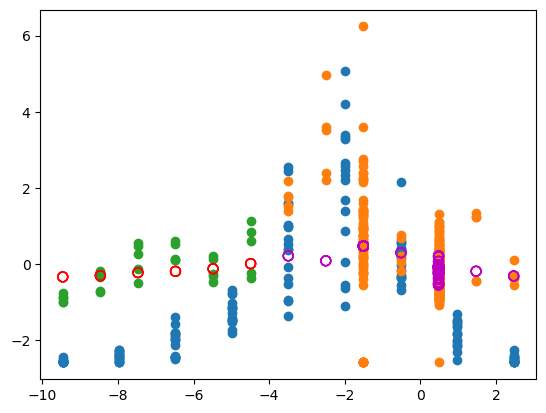

In [19]:
loaded_model = torch.jit.load('calibration.jit')

plt.clf()
ax = plt.figure().add_subplot()
ax.scatter(norm_sim_training_set_df['z_target_um'], norm_sim_training_set_df['n_protons'], label='Simulation training set')
ax.scatter(norm_expt_training_set_df['z_target_um'], norm_expt_training_set_df['n_protons'], label='Expt training set')
ax.scatter(norm_expt_test_set_df['z_target_um'], norm_expt_test_set_df['n_protons'], label='Expt test set')

with torch.no_grad():
    output = loaded_model(norm_expt_inputs_training)
    numpy_array = output.numpy() 
ax.scatter(norm_expt_training_set_df['z_target_um'], numpy_array, label=' expt train predictions', s=50, facecolors='none', edgecolors='m')

with torch.no_grad():
    output = loaded_model(norm_expt_inputs_test)
    numpy_array = output.numpy() 
ax.scatter(norm_expt_test_set_df['z_target_um'], numpy_array,label=' expt test predictions', s=50, facecolors='none', edgecolors='r')
plt.show()# loaded_model.eval()

<h2> Saving the Lume Model </h2>

In [20]:
from lume_model.models import TorchModel
from lume_model.variables import ScalarInputVariable, ScalarOutputVariable
model = TorchModel

In [22]:

input_variables = [
    ScalarInputVariable(name="z_target_um", default=0, value_range=[-150,150]),
    ScalarInputVariable(name="TOD_fs3", default=0, value_range=[-8e4,8e4]),
    ScalarInputVariable(name="GVD", default=0, value_range=[13.2,13.9])
]
output_variables = [
    ScalarOutputVariable(name="n_protons", default=0, value_range=[0,8e10])
]

calibration_transform = AffineInputTransform( 1, coefficient=calibration_layer.weight.clone(), offset=calibration_layer.bias.clone() )

model = TorchModel(
    model=sim_net,
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_transform],
    output_transformers=[calibration_transform,output_transform] # saving calibration before normalization
)

model.dump( file='base_simulation_model_with_transformers_calibration.yml' )


<h2> LoadingModel </h2>

In [23]:
loaded_model = TorchModel('base_simulation_model_with_transformers_calibration.yml')

<Figure size 640x480 with 0 Axes>

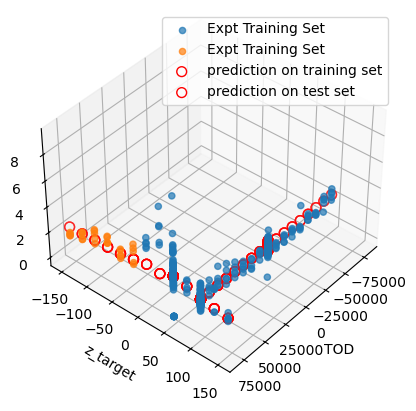

In [24]:
plt.clf()
ax = plt.figure().add_subplot(projection='3d')


expt_training_set_df = pd.read_csv('../../experimental_data/training_set_1.csv')
expt_test_set_df = pd.read_csv('../../experimental_data/test_set_1.csv')


ax.scatter( expt_training_set_df['TOD_fs3'], expt_training_set_df['z_target_um'],
            expt_training_set_df['n_protons'], alpha=0.7, label='Expt Training Set')
ax.scatter( expt_test_set_df['TOD_fs3'], expt_test_set_df['z_target_um'],
            expt_test_set_df['n_protons'], alpha=0.7, label='Expt Training Set')

n_predict = loaded_model.evaluate(
    {label: torch.tensor( expt_training_set_df[label].values ) for label in ['z_target_um', 'TOD_fs3', 'GVD']})
ax.scatter( expt_training_set_df['TOD_fs3'], expt_training_set_df['z_target_um'],
           n_predict['n_protons'], s=50, facecolors='none', edgecolors='r', label='prediction on training set')


n_predict = loaded_model.evaluate(
    {label: torch.tensor( expt_test_set_df[label].values ) for label in ['z_target_um', 'TOD_fs3', 'GVD']})
ax.scatter( expt_test_set_df['TOD_fs3'], expt_test_set_df['z_target_um'],
           n_predict['n_protons'], s=50, facecolors='none', edgecolors='r', label='prediction on test set')

ax.view_init(elev=40., azim=40, roll=0)
plt.xlabel('TOD')
plt.ylabel('z_target')
plt.legend()

<Figure size 640x480 with 0 Axes>

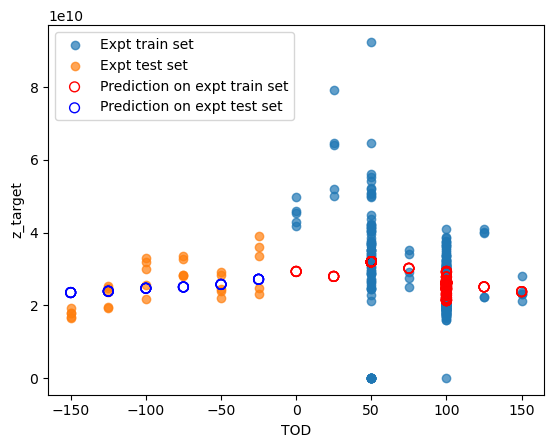

In [25]:
plt.clf()
ax = plt.figure().add_subplot()


expt_training_set_df = pd.read_csv('../../experimental_data/training_set_1.csv')
expt_test_set_df = pd.read_csv('../../experimental_data/test_set_1.csv')

ax.scatter( expt_training_set_df['z_target_um'],
            expt_training_set_df['n_protons'], alpha=0.7, label='Expt train set')
ax.scatter( expt_test_set_df['z_target_um'],
           expt_test_set_df['n_protons'], alpha=0.7, label='Expt test set')


n_predict = loaded_model.evaluate(
    {label: torch.tensor( expt_training_set_df[label].values ) for label in ['z_target_um', 'TOD_fs3', 'GVD']})
ax.scatter( expt_training_set_df['z_target_um'],
           n_predict['n_protons'], s=50, facecolors='none', edgecolors='r', label='Prediction on expt train set')


n_predict = loaded_model.evaluate(
    {label: torch.tensor( expt_test_set_df[label].values ) for label in ['z_target_um', 'TOD_fs3', 'GVD']})
ax.scatter( expt_test_set_df['z_target_um'],
           n_predict['n_protons'], s=50, facecolors='none', edgecolors='b', label='Prediction on expt test set')


plt.xlabel('TOD')
plt.ylabel('z_target')
plt.legend()